In [2]:
import pandas as pd
import numpy as np
from imblearn.combine import SMOTETomek
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder as LE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
from catboost import CatBoostClassifier

print("All libraries loaded")

All libraries loaded


In [3]:
try:
    data = pd.read_csv('informacion_completa_imagenes_V2.csv')
    print("Datos cargados exitosamente.")
except Exception as e:
    print(f"Error al cargar los datos: {e}")
    
print(data.info())

print(data.columns)


Datos cargados exitosamente.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   nombre de la imagen               226 non-null    object 
 1   Ángulo entre manecillas           226 non-null    float64
 2   Ángulo manecillas 2pm             226 non-null    float64
 3   Ángulo manecillas 11am            226 non-null    float64
 4   Lowest point                      226 non-null    object 
 5   longitud_manecilla_2pm            226 non-null    float64
 6   longitud_manecilla_11am           226 non-null    float64
 7   Números detectados correctamente  226 non-null    int64  
 8   Números con error espacial        226 non-null    int64  
 9   Números algo detectado            226 non-null    int64  
 10  Total numeros detectados          226 non-null    int64  
 11  Puntuacion contorno               226 non-

In [4]:
data = data.astype({col: 'float64' for col in data.select_dtypes(include='bool').columns})
data[['lowest_point_x', 'lowest_point_y']] = data['Lowest point'].str.strip('()').str.split(',', expand=True).astype(float)
data['longitud_relativa_2pm'] = data['longitud_manecilla_2pm' ] / data['Area Circulo']
data['longitud_relativa_11pm'] = data['longitud_manecilla_11am' ] / data['Area Circulo']

data.drop(columns=['nombre de la imagen','longitud_manecilla_2pm','longitud_manecilla_11am','Lowest point','Diagnostico '],inplace=True)


data = data[data['Tipo'] != 'PR']
data.dropna(subset=['Tipo'], inplace=True)

data['Tipo'] = data['Tipo'].map({'PD': 0, 'HC': 1})
data['Tipo'].fillna(0, inplace=True)

data = data.dropna()

conteo_clases = data['Tipo'].value_counts()

print(conteo_clases)
print(data.info())

Tipo
0    151
1     45
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 0 to 225
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Ángulo entre manecillas           196 non-null    float64
 1   Ángulo manecillas 2pm             196 non-null    float64
 2   Ángulo manecillas 11am            196 non-null    float64
 3   Números detectados correctamente  196 non-null    int64  
 4   Números con error espacial        196 non-null    int64  
 5   Números algo detectado            196 non-null    int64  
 6   Total numeros detectados          196 non-null    int64  
 7   Puntuacion contorno               196 non-null    int64  
 8   Puntuacion manecillas             196 non-null    int64  
 9   Puntuacion numeros                196 non-null    int64  
 10  puntuacion final                  196 non-null    int64  
 11  Area Circulo               

In [5]:
X = data.drop(columns=['Tipo'])
y = data['Tipo']

X = X.dropna()
y = y[X.index]


numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 0 to 225
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Ángulo entre manecillas           196 non-null    float64
 1   Ángulo manecillas 2pm             196 non-null    float64
 2   Ángulo manecillas 11am            196 non-null    float64
 3   Números detectados correctamente  196 non-null    int64  
 4   Números con error espacial        196 non-null    int64  
 5   Números algo detectado            196 non-null    int64  
 6   Total numeros detectados          196 non-null    int64  
 7   Puntuacion contorno               196 non-null    int64  
 8   Puntuacion manecillas             196 non-null    int64  
 9   Puntuacion numeros                196 non-null    int64  
 10  puntuacion final                  196 non-null    int64  
 11  Area Circulo                      196 non-null    float64
 12  Circularidad 

Datos de entrenamiento: (147, 21), Datos de validación: (63, 21), Datos de prueba ciega: (40, 21)


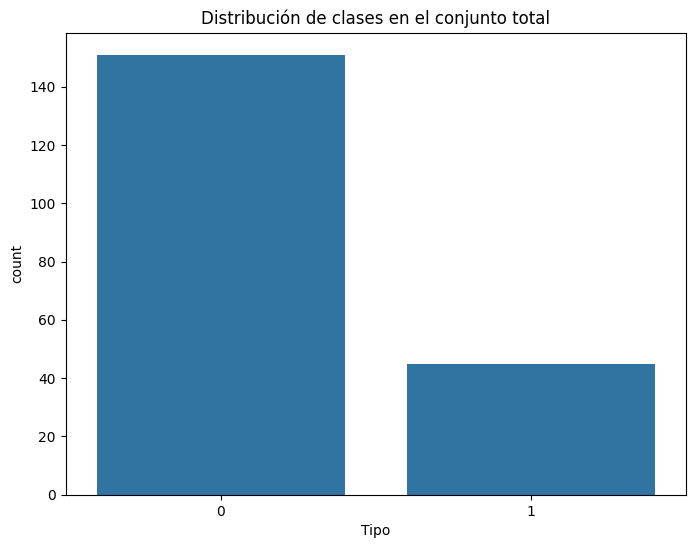

Tipo
0    151
1     45
Name: count, dtype: int64


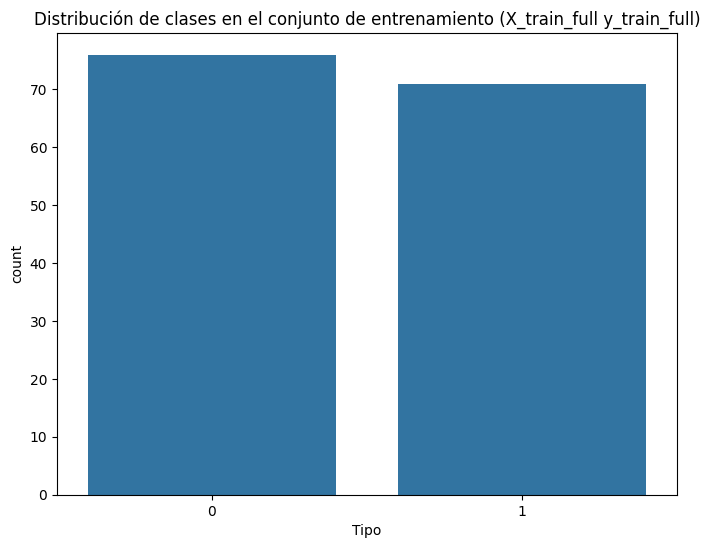

Tipo
0    76
1    71
Name: count, dtype: int64


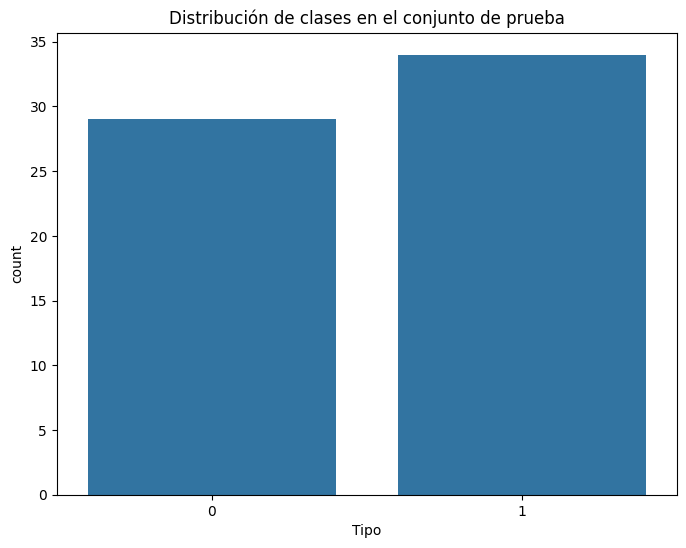

Tipo
1    34
0    29
Name: count, dtype: int64


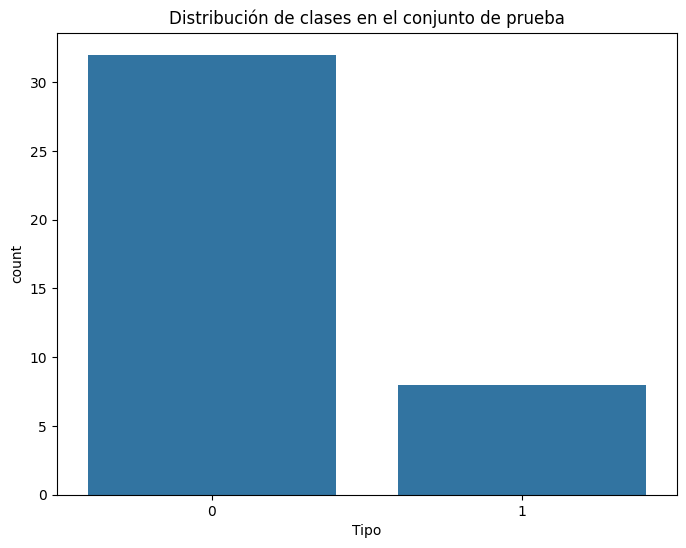

Tipo
0    32
1     8
Name: count, dtype: int64


In [7]:
X_train, X_test_blind, y_train, y_test_blind = train_test_split(X, y, test_size=0.2, random_state=42)  

smote = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

print(f"Datos de entrenamiento: {X_train_full.shape}, Datos de validación: {X_test_full.shape}, Datos de prueba ciega: {X_test_blind.shape}")

plt.figure(figsize=(8,6))
sns.countplot(x=y)
plt.title('Distribución de clases en el conjunto total')
plt.show()
print(y.value_counts())

plt.figure(figsize=(8,6))
sns.countplot(x=y_train_full)
plt.title('Distribución de clases en el conjunto de entrenamiento (X_train_full y_train_full)')
plt.show()
print(y_train_full.value_counts())

plt.figure(figsize=(8,6))
sns.countplot(x=y_test_full)
plt.title('Distribución de clases en el conjunto de prueba')
plt.show()
print(y_test_full.value_counts())

plt.figure(figsize=(8,6))
sns.countplot(x=y_test_blind)
plt.title('Distribución de clases en el conjunto de prueba')
plt.show()
print(y_test_blind.value_counts())

MODELO LGBM

In [8]:
lgb_model = lgb.LGBMClassifier(random_state=42)

param_dist_lgbm = {
    'num_leaves': [31, 50, 70, 100, 150],
    'max_depth': [-1, 5, 10, 15, 20],
    'learning_rate': [0.1, 0.01, 0.05, 0.005, 0.001],
    'n_estimators': [100, 200, 300, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_samples': [20, 30, 50],
    'min_child_weight': [1e-3, 1e-2, 1e-1, 1],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [0, 0.1, 1, 10]
}


random_search_lgbm = RandomizedSearchCV(
    estimator=lgb_model, 
    param_distributions=param_dist_lgbm, 
    n_iter=30, 
    scoring='f1', 
    cv=5,  
    random_state=42, 
    n_jobs=-1
)

In [9]:
random_search_lgbm.fit(X_train_full, y_train_full)

y_pred = random_search_lgbm.best_estimator_.predict(X_test_full)

print("Accuracy:", accuracy_score(y_test_full, y_pred))
print("Precision:", precision_score(y_test_full, y_pred))
print("Recall:", recall_score(y_test_full, y_pred))
print("F1 Score:", f1_score(y_test_full, y_pred))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 71, number of negative: 76
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 537
[LightGBM] [Info] Number of data points in the train set: 147, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482993 -> initscore=-0.068053
[LightGBM] [Info] Start training from score -0.068053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [10]:
y_val_pred_lgmb = random_search_lgbm.predict(X_test_full)

print("Evaluación en el conjunto de validación con el modelo lgbm:")
print(f"Accuracy: {accuracy_score(y_test_full, y_val_pred_lgmb):.4f}")
print(f"Precision: {precision_score(y_test_full, y_val_pred_lgmb, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test_full, y_val_pred_lgmb, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test_full, y_val_pred_lgmb, average='weighted'):.4f}")
print("\nReporte de clasificación:\n" + classification_report(y_test_full, y_val_pred_lgmb))


Evaluación en el conjunto de validación con el modelo lgbm:
Accuracy: 0.8413
Precision: 0.8520
Recall: 0.8413
F1 Score: 0.8385

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.91      0.72      0.81        29
           1       0.80      0.94      0.86        34

    accuracy                           0.84        63
   macro avg       0.86      0.83      0.84        63
weighted avg       0.85      0.84      0.84        63



In [11]:
y_test_blind_pred_lgbm = random_search_lgbm.best_estimator_.predict(X_test_blind)
print("Evaluación en conjunto de prueba ciega con el modelo lgbm:")
print(f"Accuracy: {accuracy_score(y_test_blind, y_test_blind_pred_lgbm):.4f}")
print(f"Precision: {precision_score(y_test_blind, y_test_blind_pred_lgbm):.4f}")
print(f"Recall: {recall_score(y_test_blind, y_test_blind_pred_lgbm):.4f}")
print(f"F1 Score: {f1_score(y_test_blind, y_test_blind_pred_lgbm):.4f}")


Evaluación en conjunto de prueba ciega con el modelo lgbm:
Accuracy: 0.7500
Precision: 0.3750
Recall: 0.3750
F1 Score: 0.3750


In [12]:
y_test_pred_lgmb = random_search_lgbm.best_estimator_.predict(X_train)
print("Evaluación en conjunto train original con el modleo lgbm:")
print(f"Accuracy: {accuracy_score(y_train, y_test_pred_lgmb):.4f}")
print(f"Precision: {precision_score(y_train, y_test_pred_lgmb):.4f}")
print(f"Recall: {recall_score(y_train, y_test_pred_lgmb):.4f}")
print(f"F1 Score: {f1_score(y_train, y_test_pred_lgmb):.4f}")


Evaluación en conjunto train original con el modleo lgbm:
Accuracy: 0.8846
Precision: 0.7317
Recall: 0.8108
F1 Score: 0.7692


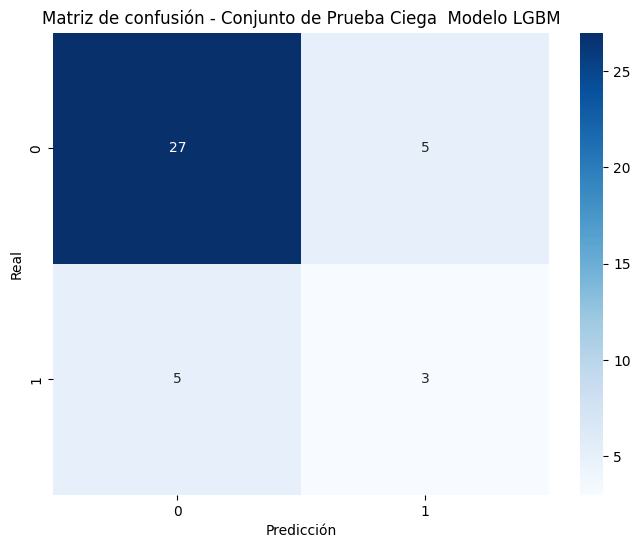

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_blind, y_test_blind_pred_lgbm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matriz de confusión - Conjunto de Prueba Ciega  Modelo LGBM')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


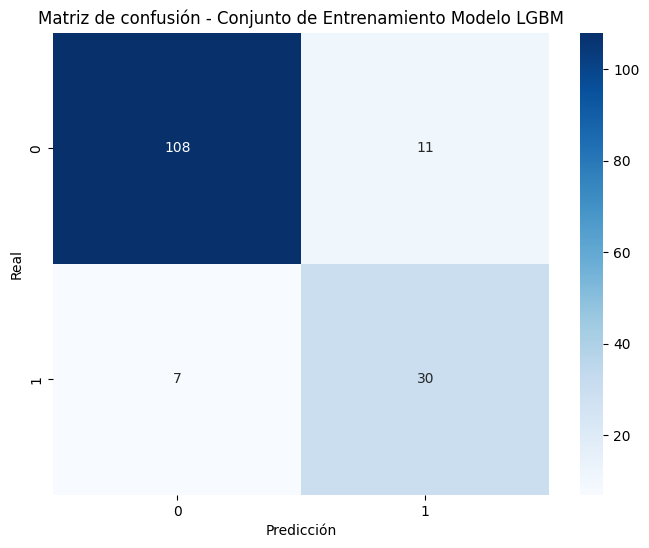

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_train, y_test_pred_lgmb)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matriz de confusión - Conjunto de Entrenamiento Modelo LGBM')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


MODELO CATBOOST 

In [15]:
catboost_model = CatBoostClassifier(random_state=42, silent=True)

param_dist_cat = {
    'depth': [4, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [200, 500, 1000],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 64, 128]
}
random_search_cat = RandomizedSearchCV(
    estimator=catboost_model, 
    param_distributions=param_dist_cat, 
    n_iter=20,  
    scoring='f1', 
    cv=5, 
    verbose=1, 
    random_state=42, 
    n_jobs=-1
)


In [16]:
random_search_cat.fit(X_train_full, y_train_full)

y_pred_lgbm = random_search_cat.best_estimator_.predict(X_test_full)

print("Accuracy:", accuracy_score(y_test_full, y_pred))
print("Precision:", precision_score(y_test_full, y_pred))
print("Recall:", recall_score(y_test_full, y_pred))
print("F1 Score:", f1_score(y_test_full, y_pred))

print("Mejor hiperparámetro encontrado:", random_search_cat.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Accuracy: 0.8412698412698413
Precision: 0.8
Recall: 0.9411764705882353
F1 Score: 0.8648648648648649
Mejor hiperparámetro encontrado: {'learning_rate': 0.01, 'l2_leaf_reg': 1, 'iterations': 1000, 'depth': 4, 'border_count': 64}


In [17]:
y_test_blind_pred_cat = random_search_cat.best_estimator_.predict(X_test_blind)
print("Evaluación en conjunto de prueba ciega con el modelo catboost:")
print(f"Accuracy: {accuracy_score(y_test_blind, y_test_blind_pred_cat):.4f}")
print(f"Precision: {precision_score(y_test_blind, y_test_blind_pred_cat):.4f}")
print(f"Recall: {recall_score(y_test_blind, y_test_blind_pred_cat):.4f}")
print(f"F1 Score: {f1_score(y_test_blind, y_test_blind_pred_cat):.4f}")


Evaluación en conjunto de prueba ciega con el modelo catboost:
Accuracy: 0.8000
Precision: 0.5000
Recall: 0.3750
F1 Score: 0.4286


In [18]:
y_test_pred_cat = random_search_cat.best_estimator_.predict(X_train)
print("Evaluación en conjunto train original con el modelo catboost:")
print(f"Accuracy: {accuracy_score(y_train, y_test_pred_cat):.4f}")
print(f"Precision: {precision_score(y_train, y_test_pred_cat):.4f}")
print(f"Recall: {recall_score(y_train, y_test_pred_cat):.4f}")
print(f"F1 Score: {f1_score(y_train, y_test_pred_cat):.4f}")


Evaluación en conjunto train original con el modelo catboost:
Accuracy: 0.9103
Precision: 0.8108
Recall: 0.8108
F1 Score: 0.8108


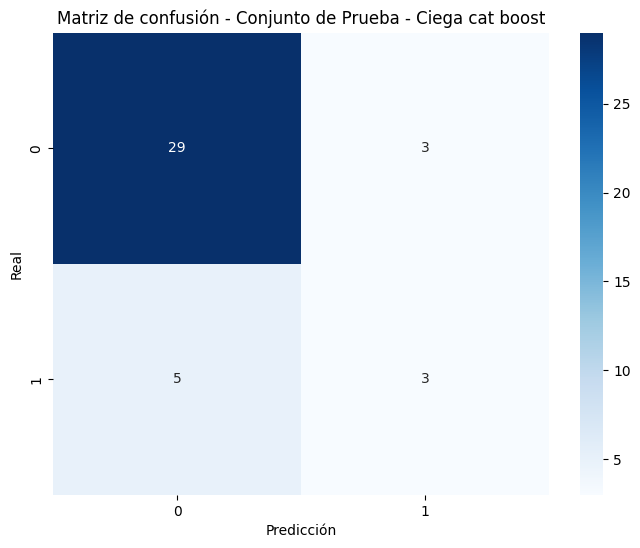

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_blind, y_test_blind_pred_cat)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matriz de confusión - Conjunto de Prueba - Ciega cat boost')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


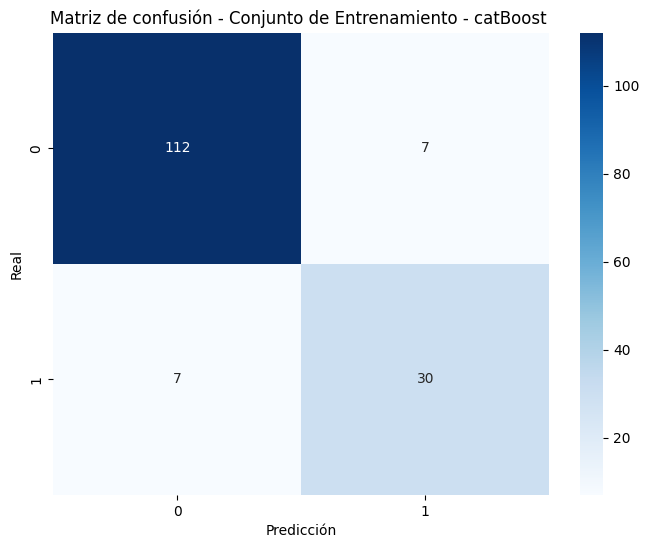

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_train, y_test_pred_cat)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matriz de confusión - Conjunto de Entrenamiento - catBoost ')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


Características más importantes en CatBoostClassifier:
Ángulo entre manecillas    11.401560
Manecilla 11 correcta       9.117776
Ángulo manecillas 2pm       8.553902
lowest_point_y              7.361132
Ángulo manecillas 11am      7.200047
Circularidad                6.995856
Manecilla 2 correcta        6.679424
Area Circulo                6.536473
longitud_relativa_11pm      5.937401
Round                       5.216490
dtype: float64


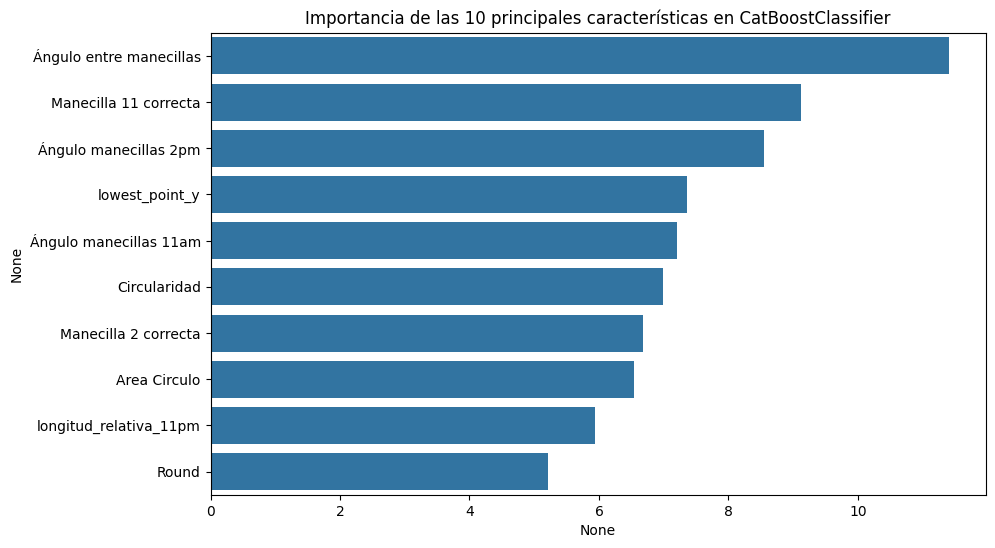

In [21]:
feature_importances = random_search_cat.best_estimator_.get_feature_importance()
importancias_catboost = pd.Series(feature_importances, index=X_train_full.columns).sort_values(ascending=False)

print("Características más importantes en CatBoostClassifier:")
print(importancias_catboost.head(10))

plt.figure(figsize=(10,6))
sns.barplot(x=importancias_catboost.head(10), y=importancias_catboost.index[:10])
plt.title("Importancia de las 10 principales características en CatBoostClassifier")
plt.show()

Características más importantes en LGBMClassifier:
Area Circulo               153
Ángulo manecillas 2pm      135
lowest_point_x             116
Ángulo manecillas 11am     110
Round                      108
Ángulo entre manecillas    107
Manecilla 2 correcta        96
lowest_point_y              85
longitud_relativa_11pm      83
Circularidad                79
dtype: int32


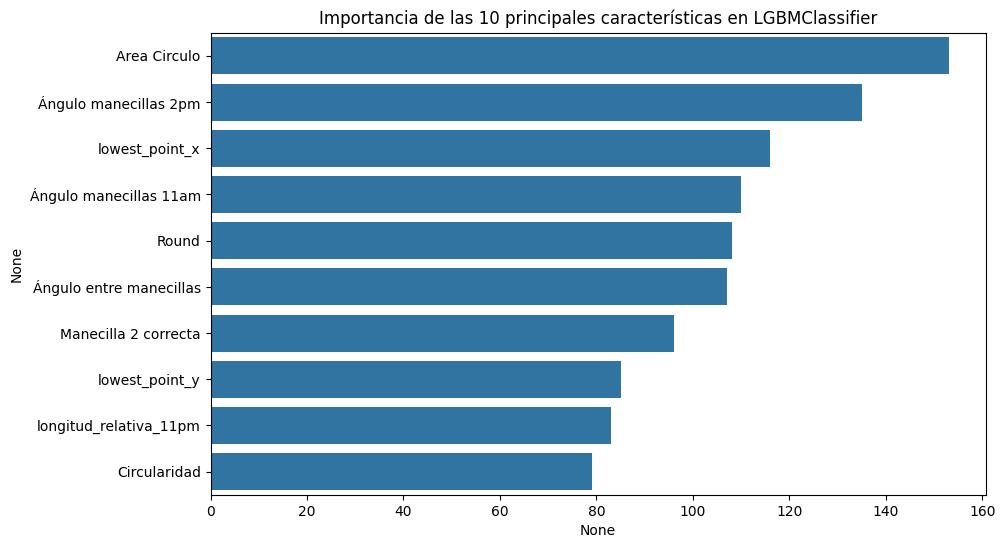

In [22]:
feature_importances = random_search_lgbm.best_estimator_.feature_importances_
importancias_lgb = pd.Series(feature_importances, index=X_train_full.columns).sort_values(ascending=False)

print("Características más importantes en LGBMClassifier:")
print(importancias_lgb.head(10))

plt.figure(figsize=(10,6))
sns.barplot(x=importancias_lgb.head(10), y=importancias_lgb.index[:10])
plt.title("Importancia de las 10 principales características en LGBMClassifier")
plt.show()

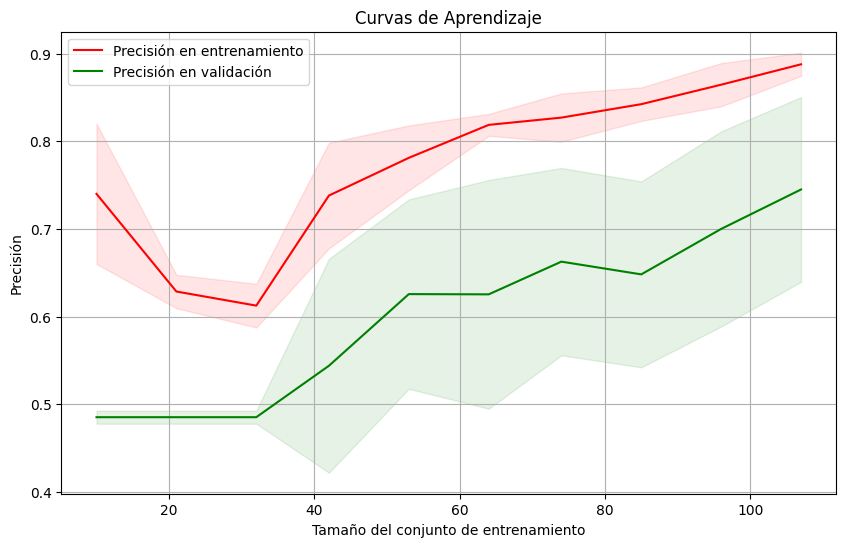

In [14]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    random_search_lgbm.best_estimator_, X_train_full, y_train_full, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Precisión en entrenamiento", color="r")
plt.plot(train_sizes, test_scores_mean, label="Precisión en validación", color="g")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, color="g", alpha=0.1)

# Títulos y etiquetas
plt.title("Curvas de Aprendizaje")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Precisión")
plt.legend(loc="best")
plt.grid()
plt.show()

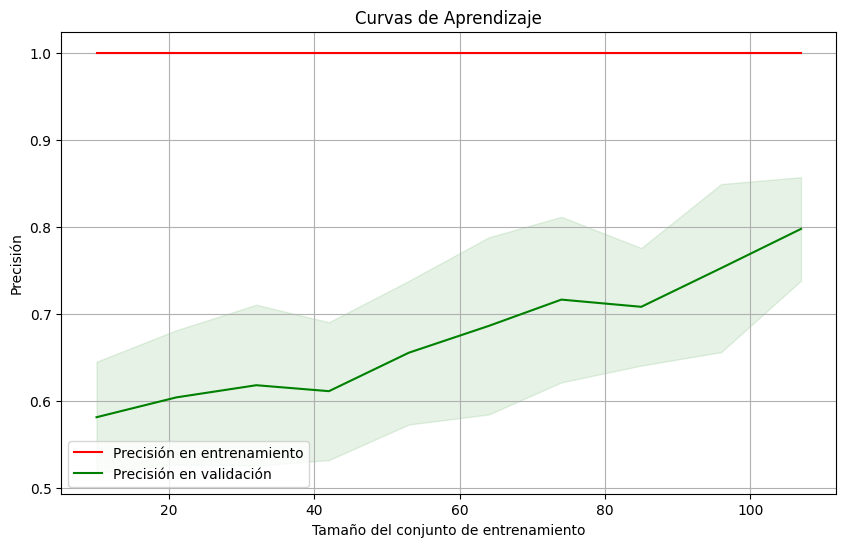

In [22]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    random_search_cat.best_estimator_, X_train_full, y_train_full, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Precisión en entrenamiento", color="r")
plt.plot(train_sizes, test_scores_mean, label="Precisión en validación", color="g")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, color="g", alpha=0.1)

# Títulos y etiquetas
plt.title("Curvas de Aprendizaje")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Precisión")
plt.legend(loc="best")
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
y_proba = random_search_lgbm.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
